## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [38]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [43]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0,0.4,0.8]
redice_lr_patient = [2,5,10]

In [44]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    if optim == optimizer_set[0]:
        optim2 = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95)
        print("SGD-Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    elif optim == optimizer_set[1]:
        optim2 = keras.optimizers.Adam(lr=LEARNING_RATE)
        print("Adam-Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    else:
        optim2 = keras.optimizers.RMSprop(lr=LEARNING_RATE)
        print("RMSprop-Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
                    
    model = build_mlp(input_shape=x_train.shape[1:])
    #model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim2)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    if optim == optimizer_set[0]:
        exp_name_tag = ("SGD-%s-RF-%.1f-RP-%s" % (i,reduce_factor,reduce_patient))
    elif optim == optimizer_set[1]:
        exp_name_tag = ("Ad-%s-RF-%.1f-RP-%s" % (i,reduce_factor,reduce_patient))
    else:
        exp_name_tag = ("RMS-%s-RF-%.1f-RP-%s" % (i,reduce_factor,reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

SGD-Numbers of exp: 0, reduce_factor: 0.00, reduce_patient: 2
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 223us/step - loss: 2.2690 - acc: 0.2628 - val_loss: 2.2477 - val_acc: 0.2950
Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.7687 - acc: 0.3865 - val_loss: 1.8557 - val_acc: 0.3629
Epoch 3/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.6370 - acc: 0.4300 - val_loss: 1.7077 - val_acc: 0.4036
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5637 - acc: 0.4534 - val_loss: 1.6597 - val_acc: 0.4196
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5101 - acc: 0.4725 - val_loss: 1.6218 - val_acc: 0.4366
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4682 - acc: 0.4865 - val_loss: 1.5784 - val_acc: 0.4466
Epoch 7/50
50000/50000 [==============================] - 2s 40u

50000/50000 [==============================] - 2s 40us/step - loss: 1.3877 - acc: 0.5171 - val_loss: 1.5299 - val_acc: 0.4601
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.3600 - acc: 0.5268 - val_loss: 1.5086 - val_acc: 0.4640
Epoch 10/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3319 - acc: 0.5365 - val_loss: 1.5029 - val_acc: 0.4709
Epoch 11/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3072 - acc: 0.5465 - val_loss: 1.4936 - val_acc: 0.4697
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2813 - acc: 0.5556 - val_loss: 1.4843 - val_acc: 0.4760
Epoch 13/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2592 - acc: 0.5644 - val_loss: 1.4893 - val_acc: 0.4713
Epoch 14/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.2396 - acc: 0.5695 - val_loss: 1.4850 - val_acc: 0.4799
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 2s 41us/step - loss: 1.2052 - acc: 0.5838 - val_loss: 1.4713 - val_acc: 0.4881
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1873 - acc: 0.5908 - val_loss: 1.4636 - val_acc: 0.4864
Epoch 18/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.1665 - acc: 0.5970 - val_loss: 1.4602 - val_acc: 0.4892
Epoch 19/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1501 - acc: 0.6050 - val_loss: 1.4657 - val_acc: 0.4903
Epoch 20/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.1319 - acc: 0.6106 - val_loss: 1.4567 - val_acc: 0.4917
Epoch 21/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1151 - acc: 0.6181 - val_loss: 1.4559 - val_acc: 0.4906
Epoch 22/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0956 - acc: 0.6244 - val_loss: 1.4579 - val_acc: 0.4925
Epoch 23/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 41us/step - loss: 1.1628 - acc: 0.6000 - val_loss: 1.4357 - val_acc: 0.4979
Epoch 24/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1567 - acc: 0.6019 - val_loss: 1.4363 - val_acc: 0.4968
Epoch 25/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1533 - acc: 0.6022 - val_loss: 1.4340 - val_acc: 0.4998
Epoch 26/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1501 - acc: 0.6042 - val_loss: 1.4347 - val_acc: 0.4970
Epoch 27/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1464 - acc: 0.6056 - val_loss: 1.4343 - val_acc: 0.4984

Epoch 00027: ReduceLROnPlateau reducing learning rate to 6.40000042039901e-05.
Epoch 28/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1417 - acc: 0.6076 - val_loss: 1.4322 - val_acc: 0.4980
Epoch 29/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1394 - acc: 0.6072 - v

Epoch 26/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0255 - acc: 0.6506 - val_loss: 1.4592 - val_acc: 0.4959

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 27/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0017 - acc: 0.6605 - val_loss: 1.4484 - val_acc: 0.4986
Epoch 28/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9882 - acc: 0.6667 - val_loss: 1.4460 - val_acc: 0.4995
Epoch 29/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9801 - acc: 0.6694 - val_loss: 1.4405 - val_acc: 0.5043
Epoch 30/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9737 - acc: 0.6716 - val_loss: 1.4495 - val_acc: 0.4997
Epoch 31/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9669 - acc: 0.6735 - val_loss: 1.4455 - val_acc: 0.5020
Epoch 32/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9604 - ac

50000/50000 [==============================] - 2s 42us/step - loss: 0.9665 - acc: 0.6708 - val_loss: 1.4411 - val_acc: 0.5003
Epoch 32/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9516 - acc: 0.6782 - val_loss: 1.4525 - val_acc: 0.4987
Epoch 33/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9363 - acc: 0.6830 - val_loss: 1.4327 - val_acc: 0.4985
Epoch 34/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9233 - acc: 0.6874 - val_loss: 1.4546 - val_acc: 0.5006

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 35/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9010 - acc: 0.6983 - val_loss: 1.4396 - val_acc: 0.5032
Epoch 36/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8861 - acc: 0.7044 - val_loss: 1.4326 - val_acc: 0.5045
Epoch 37/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8797 - acc: 0.7085 - 

50000/50000 [==============================] - 2s 41us/step - loss: 0.9613 - acc: 0.6763 - val_loss: 1.4331 - val_acc: 0.5024

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
Epoch 36/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9546 - acc: 0.6777 - val_loss: 1.4380 - val_acc: 0.5004
Epoch 37/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9491 - acc: 0.6800 - val_loss: 1.4336 - val_acc: 0.5037

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
Epoch 38/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9432 - acc: 0.6832 - val_loss: 1.4336 - val_acc: 0.5045
Epoch 39/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9386 - acc: 0.6859 - val_loss: 1.4361 - val_acc: 0.5043

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
Epoch 40/50
50000/50000 [==============================] - 2s 41us/step - los

Epoch 38/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8828 - acc: 0.7059 - val_loss: 1.4602 - val_acc: 0.4976

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Epoch 39/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8711 - acc: 0.7107 - val_loss: 1.4596 - val_acc: 0.5032
Epoch 40/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8617 - acc: 0.7147 - val_loss: 1.4656 - val_acc: 0.5004
Epoch 41/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8533 - acc: 0.7172 - val_loss: 1.4733 - val_acc: 0.4994
Epoch 42/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.8457 - acc: 0.7213 - val_loss: 1.4653 - val_acc: 0.5032
Epoch 43/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8381 - acc: 0.7239 - val_loss: 1.4801 - val_acc: 0.4965

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 44/

50000/50000 [==============================] - 2s 41us/step - loss: 0.7849 - acc: 0.7476 - val_loss: 1.4940 - val_acc: 0.5048
Epoch 45/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7736 - acc: 0.7501 - val_loss: 1.4965 - val_acc: 0.5008
Epoch 46/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7609 - acc: 0.7559 - val_loss: 1.5053 - val_acc: 0.4999
Epoch 47/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.7498 - acc: 0.7591 - val_loss: 1.5115 - val_acc: 0.5012
Epoch 48/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7370 - acc: 0.7645 - val_loss: 1.5155 - val_acc: 0.4989

Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 49/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7232 - acc: 0.7701 - val_loss: 1.5078 - val_acc: 0.5025
Epoch 50/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7115 - acc: 0.7751 - 

50000/50000 [==============================] - 13s 257us/step - loss: 1.7777 - acc: 0.3818 - val_loss: 1.9541 - val_acc: 0.3623
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4744 - acc: 0.4792 - val_loss: 1.7010 - val_acc: 0.4081
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3668 - acc: 0.5167 - val_loss: 1.8170 - val_acc: 0.3676
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2833 - acc: 0.5471 - val_loss: 1.6593 - val_acc: 0.4153
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2169 - acc: 0.5726 - val_loss: 1.8470 - val_acc: 0.3715
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1574 - acc: 0.5917 - val_loss: 1.6251 - val_acc: 0.4296
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1078 - acc: 0.6114 - val_loss: 1.9761 - val_acc: 0.3804
Epoch 8/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 43us/step - loss: 1.0076 - acc: 0.6462 - val_loss: 1.6117 - val_acc: 0.4459
Epoch 10/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9675 - acc: 0.6625 - val_loss: 1.8663 - val_acc: 0.3961
Epoch 11/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.9216 - acc: 0.6778 - val_loss: 1.6818 - val_acc: 0.4465
Epoch 12/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8818 - acc: 0.6950 - val_loss: 1.8070 - val_acc: 0.4124
Epoch 13/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.8329 - acc: 0.7127 - val_loss: 1.9237 - val_acc: 0.4105
Epoch 14/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8037 - acc: 0.7201 - val_loss: 1.8206 - val_acc: 0.4244
Epoch 15/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7642 - acc: 0.7347 - val_loss: 1.8908 - val_acc: 0.4296
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 0.8305 - acc: 0.7247 - val_loss: 1.3367 - val_acc: 0.5336
Epoch 16/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8166 - acc: 0.7309 - val_loss: 1.3384 - val_acc: 0.5359
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8085 - acc: 0.7333 - val_loss: 1.3344 - val_acc: 0.5419
Epoch 18/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8003 - acc: 0.7369 - val_loss: 1.3445 - val_acc: 0.5350
Epoch 19/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7909 - acc: 0.7415 - val_loss: 1.3457 - val_acc: 0.5383

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.560000284574926e-05.
Epoch 20/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7743 - acc: 0.7488 - val_loss: 1.3369 - val_acc: 0.5409
Epoch 21/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7687 - acc: 0.7506 - 

50000/50000 [==============================] - 2s 43us/step - loss: 0.7294 - acc: 0.7538 - val_loss: 1.4517 - val_acc: 0.5135
Epoch 15/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.6690 - acc: 0.7784 - val_loss: 1.4470 - val_acc: 0.5149
Epoch 16/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.6394 - acc: 0.7894 - val_loss: 1.4944 - val_acc: 0.4994
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.6122 - acc: 0.7992 - val_loss: 1.5343 - val_acc: 0.4990
Epoch 18/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5868 - acc: 0.8093 - val_loss: 1.5087 - val_acc: 0.5095
Epoch 19/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5568 - acc: 0.8201 - val_loss: 1.6307 - val_acc: 0.4993
Epoch 20/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5366 - acc: 0.8265 - val_loss: 1.7865 - val_acc: 0.4823

Epoch 00020: ReduceLROnPlateau reducing learn

50000/50000 [==============================] - 2s 44us/step - loss: 0.6494 - acc: 0.7748 - val_loss: 1.9820 - val_acc: 0.4331
Epoch 19/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5992 - acc: 0.7949 - val_loss: 1.7751 - val_acc: 0.4818
Epoch 20/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5752 - acc: 0.8029 - val_loss: 1.9464 - val_acc: 0.4445

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 21/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4491 - acc: 0.8602 - val_loss: 1.6029 - val_acc: 0.5154
Epoch 22/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3889 - acc: 0.8865 - val_loss: 1.6267 - val_acc: 0.5189
Epoch 23/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3612 - acc: 0.8973 - val_loss: 1.6315 - val_acc: 0.5161
Epoch 24/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.3412 - acc: 0.9039 - 

50000/50000 [==============================] - 2s 46us/step - loss: 0.4795 - acc: 0.8529 - val_loss: 1.5826 - val_acc: 0.5147
Epoch 22/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4535 - acc: 0.8658 - val_loss: 1.5815 - val_acc: 0.5091

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
Epoch 23/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4202 - acc: 0.8807 - val_loss: 1.6106 - val_acc: 0.5081
Epoch 24/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4023 - acc: 0.8870 - val_loss: 1.6145 - val_acc: 0.5145

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
Epoch 25/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3770 - acc: 0.8981 - val_loss: 1.6053 - val_acc: 0.5196
Epoch 26/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.3624 - acc: 0.9030 - val_loss: 1.6403 - val_acc: 0.5175

Epoch 00026: Reduce

50000/50000 [==============================] - 2s 44us/step - loss: 0.5518 - acc: 0.8185 - val_loss: 1.6042 - val_acc: 0.5021
Epoch 20/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.5087 - acc: 0.8372 - val_loss: 1.6996 - val_acc: 0.4852
Epoch 21/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4827 - acc: 0.8454 - val_loss: 1.7791 - val_acc: 0.4752
Epoch 22/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4528 - acc: 0.8569 - val_loss: 1.9340 - val_acc: 0.4661
Epoch 23/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4263 - acc: 0.8665 - val_loss: 1.8160 - val_acc: 0.4881

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
Epoch 24/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3725 - acc: 0.8883 - val_loss: 1.8050 - val_acc: 0.4943
Epoch 25/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3401 - acc: 0.9024 - 

50000/50000 [==============================] - 2s 43us/step - loss: 0.4503 - acc: 0.8534 - val_loss: 1.9238 - val_acc: 0.4681
Epoch 24/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.4188 - acc: 0.8655 - val_loss: 2.0496 - val_acc: 0.4522
Epoch 25/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.3913 - acc: 0.8734 - val_loss: 2.1072 - val_acc: 0.4691
Epoch 26/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.3672 - acc: 0.8832 - val_loss: 2.1606 - val_acc: 0.4642
Epoch 27/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.3380 - acc: 0.8926 - val_loss: 2.0288 - val_acc: 0.4751
Epoch 28/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.3205 - acc: 0.9006 - val_loss: 1.9768 - val_acc: 0.4850

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 29/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.2573 - acc: 0.9277 - 

50000/50000 [==============================] - 2s 45us/step - loss: 0.9571 - acc: 0.6682 - val_loss: 1.3555 - val_acc: 0.5278
Epoch 30/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.9572 - acc: 0.6663 - val_loss: 1.3555 - val_acc: 0.5279
Epoch 31/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.9569 - acc: 0.6674 - val_loss: 1.3555 - val_acc: 0.5278
Epoch 32/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.9572 - acc: 0.6676 - val_loss: 1.3556 - val_acc: 0.5278
Epoch 33/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.9572 - acc: 0.6669 - val_loss: 1.3556 - val_acc: 0.5281
Epoch 34/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9565 - acc: 0.6664 - val_loss: 1.3555 - val_acc: 0.5280
Epoch 35/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9565 - acc: 0.6665 - val_loss: 1.3555 - val_acc: 0.5276
Epoch 36/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 48us/step - loss: 0.9401 - acc: 0.6745 - val_loss: 1.3758 - val_acc: 0.5273
Epoch 38/50
50000/50000 [==============================] - 2s 49us/step - loss: 0.9395 - acc: 0.6745 - val_loss: 1.3758 - val_acc: 0.5272
Epoch 39/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.9400 - acc: 0.6730 - val_loss: 1.3758 - val_acc: 0.5272
Epoch 40/50
50000/50000 [==============================] - 3s 57us/step - loss: 0.9407 - acc: 0.6731 - val_loss: 1.3758 - val_acc: 0.5270
Epoch 41/50
50000/50000 [==============================] - 3s 56us/step - loss: 0.9395 - acc: 0.6749 - val_loss: 1.3757 - val_acc: 0.5271
Epoch 42/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.9397 - acc: 0.6742 - val_loss: 1.3758 - val_acc: 0.5274
Epoch 43/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.9402 - acc: 0.6752 - val_loss: 1.3758 - val_acc: 0.5272
Epoch 44/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 43us/step - loss: 0.5790 - acc: 0.8083 - val_loss: 1.4618 - val_acc: 0.5345
Epoch 46/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5781 - acc: 0.8083 - val_loss: 1.4618 - val_acc: 0.5343
Epoch 47/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.5789 - acc: 0.8073 - val_loss: 1.4618 - val_acc: 0.5345
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.5784 - acc: 0.8078 - val_loss: 1.4618 - val_acc: 0.5344
Epoch 49/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5778 - acc: 0.8089 - val_loss: 1.4617 - val_acc: 0.5344
Epoch 50/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5783 - acc: 0.8085 - val_loss: 1.4617 - val_acc: 0.5345
RMSprop-Numbers of exp: 21, reduce_factor: 0.40, reduce_patient: 2
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 323us

50000/50000 [==============================] - 2s 44us/step - loss: 0.7798 - acc: 0.7414 - val_loss: 1.3084 - val_acc: 0.5488
Epoch 45/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7779 - acc: 0.7445 - val_loss: 1.3084 - val_acc: 0.5489

Epoch 00045: ReduceLROnPlateau reducing learning rate to 6.871948010633844e-11.
Epoch 46/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7787 - acc: 0.7419 - val_loss: 1.3083 - val_acc: 0.5490
Epoch 47/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.7788 - acc: 0.7418 - val_loss: 1.3083 - val_acc: 0.5489

Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.748779259764689e-11.
Epoch 48/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.7788 - acc: 0.7415 - val_loss: 1.3083 - val_acc: 0.5488
Epoch 49/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.7789 - acc: 0.7431 - val_loss: 1.3083 - val_acc: 0.5489

Epoch 00049: ReduceLR

Epoch 47/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5651 - acc: 0.8262 - val_loss: 1.4097 - val_acc: 0.5388

Epoch 00047: ReduceLROnPlateau reducing learning rate to 6.553600542247295e-07.
Epoch 48/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5648 - acc: 0.8266 - val_loss: 1.4098 - val_acc: 0.5390
Epoch 49/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.5640 - acc: 0.8266 - val_loss: 1.4099 - val_acc: 0.5391
Epoch 50/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.5650 - acc: 0.8263 - val_loss: 1.4101 - val_acc: 0.5388
RMSprop-Numbers of exp: 23, reduce_factor: 0.40, reduce_patient: 10
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 340us/step - loss: 1.8510 - acc: 0.3616 - val_loss: 1.8887 - val_acc: 0.3628
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.5460 - acc: 0.4529 - val_loss

50000/50000 [==============================] - 2s 43us/step - loss: 1.5363 - acc: 0.4575 - val_loss: 2.6141 - val_acc: 0.2551
Epoch 3/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.4246 - acc: 0.4951 - val_loss: 2.5378 - val_acc: 0.2865
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3479 - acc: 0.5236 - val_loss: 3.0575 - val_acc: 0.2032
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2793 - acc: 0.5497 - val_loss: 2.0111 - val_acc: 0.3413
Epoch 6/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.2236 - acc: 0.5670 - val_loss: 1.8886 - val_acc: 0.3859
Epoch 7/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1681 - acc: 0.5858 - val_loss: 2.0788 - val_acc: 0.3342
Epoch 8/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.1318 - acc: 0.6003 - val_loss: 1.9282 - val_acc: 0.3684

Epoch 00008: ReduceLROnPlateau reducing learning ra

50000/50000 [==============================] - 2s 45us/step - loss: 0.2738 - acc: 0.9386 - val_loss: 1.7180 - val_acc: 0.5298

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.1529216135386379e-05.
RMSprop-Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 5
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 349us/step - loss: 1.8371 - acc: 0.3668 - val_loss: 2.0417 - val_acc: 0.3053
Epoch 2/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.5391 - acc: 0.4568 - val_loss: 3.1334 - val_acc: 0.2067
Epoch 3/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.4267 - acc: 0.4942 - val_loss: 2.4728 - val_acc: 0.2860
Epoch 4/50
50000/50000 [==============================] - 2s 47us/step - loss: 1.3483 - acc: 0.5238 - val_loss: 2.2329 - val_acc: 0.3127
Epoch 5/50
50000/50000 [==============================] - 2s 49us/step - loss: 1.2785 - acc: 0.5483 - val_loss: 1.8758 - val_

50000/50000 [==============================] - 2s 43us/step - loss: 1.4211 - acc: 0.4959 - val_loss: 2.5205 - val_acc: 0.2826.4290 - acc: 
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3450 - acc: 0.5231 - val_loss: 2.2548 - val_acc: 0.3180
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2789 - acc: 0.5474 - val_loss: 1.9039 - val_acc: 0.3716
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2205 - acc: 0.5691 - val_loss: 1.7094 - val_acc: 0.4174
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1682 - acc: 0.5891 - val_loss: 1.9520 - val_acc: 0.3697
Epoch 8/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.1276 - acc: 0.6038 - val_loss: 2.3651 - val_acc: 0.3264
Epoch 9/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.0860 - acc: 0.6196 - val_loss: 1.6304 - val_acc: 0.4398
Epoch 10/50
50000/50000 [==============

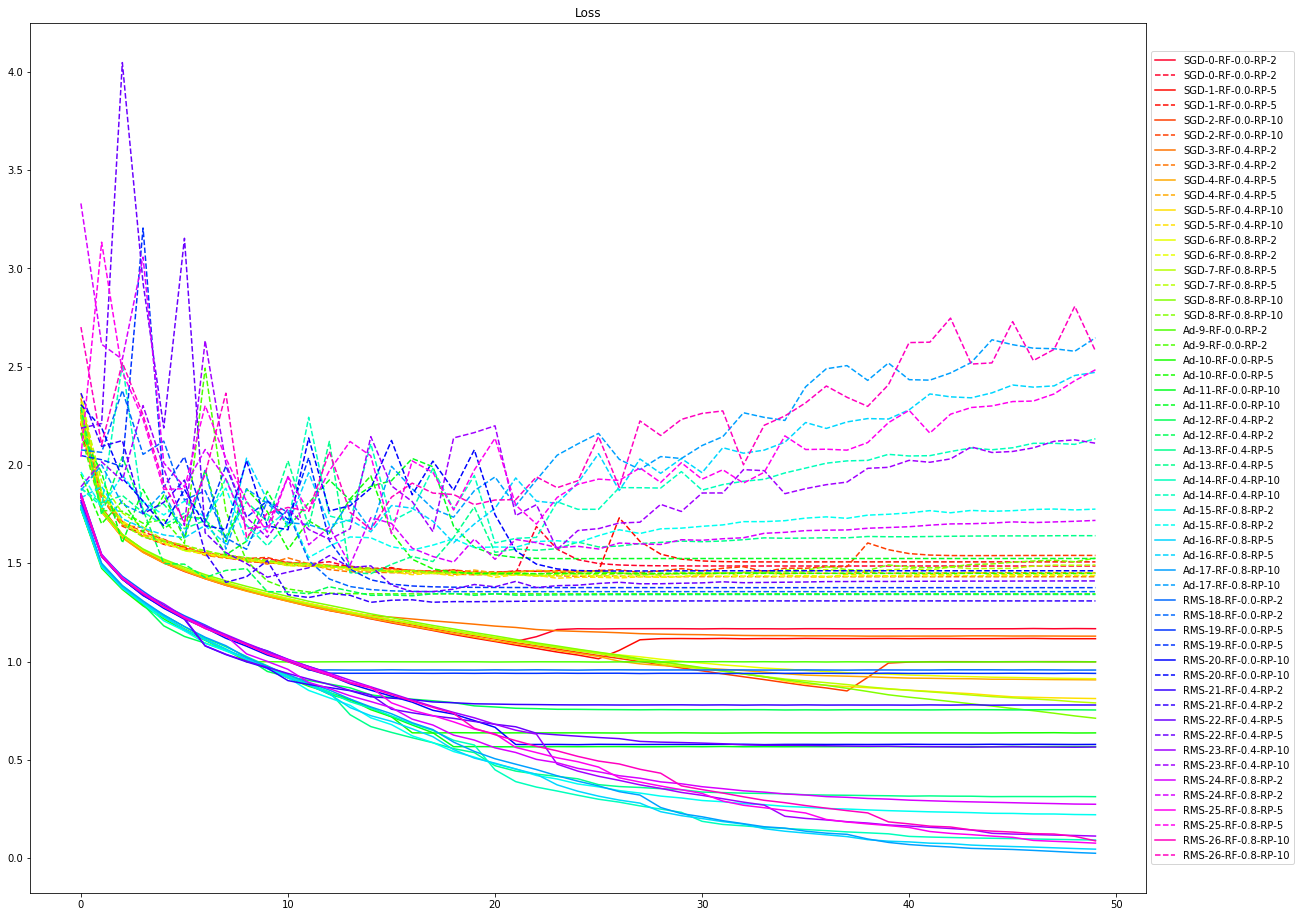

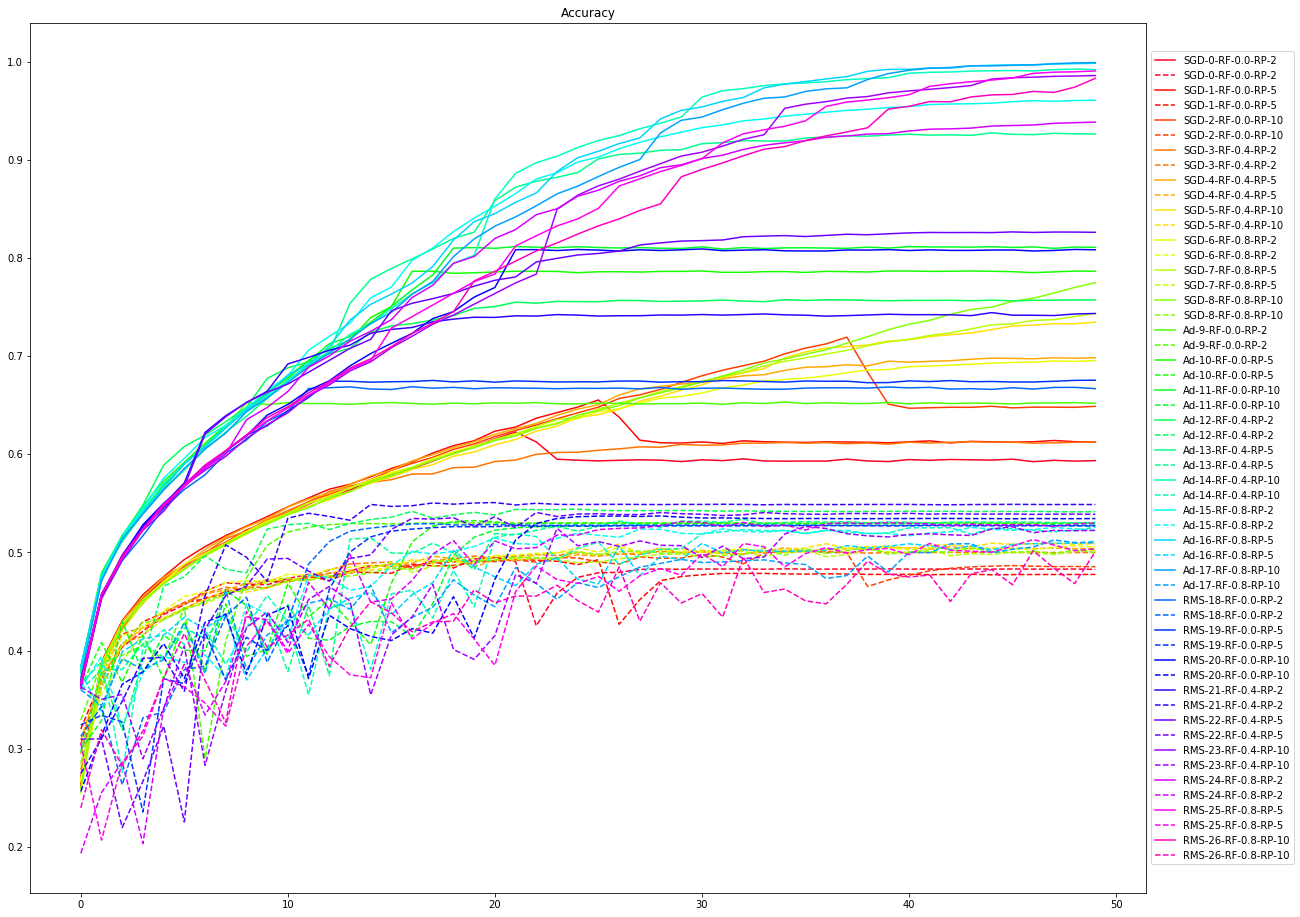

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(20,16))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(20,16))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [46]:
results.keys()

dict_keys(['SGD-0-RF-0.0-RP-2', 'SGD-1-RF-0.0-RP-5', 'SGD-2-RF-0.0-RP-10', 'SGD-3-RF-0.4-RP-2', 'SGD-4-RF-0.4-RP-5', 'SGD-5-RF-0.4-RP-10', 'SGD-6-RF-0.8-RP-2', 'SGD-7-RF-0.8-RP-5', 'SGD-8-RF-0.8-RP-10', 'Ad-9-RF-0.0-RP-2', 'Ad-10-RF-0.0-RP-5', 'Ad-11-RF-0.0-RP-10', 'Ad-12-RF-0.4-RP-2', 'Ad-13-RF-0.4-RP-5', 'Ad-14-RF-0.4-RP-10', 'Ad-15-RF-0.8-RP-2', 'Ad-16-RF-0.8-RP-5', 'Ad-17-RF-0.8-RP-10', 'RMS-18-RF-0.0-RP-2', 'RMS-19-RF-0.0-RP-5', 'RMS-20-RF-0.0-RP-10', 'RMS-21-RF-0.4-RP-2', 'RMS-22-RF-0.4-RP-5', 'RMS-23-RF-0.4-RP-10', 'RMS-24-RF-0.8-RP-2', 'RMS-25-RF-0.8-RP-5', 'RMS-26-RF-0.8-RP-10'])

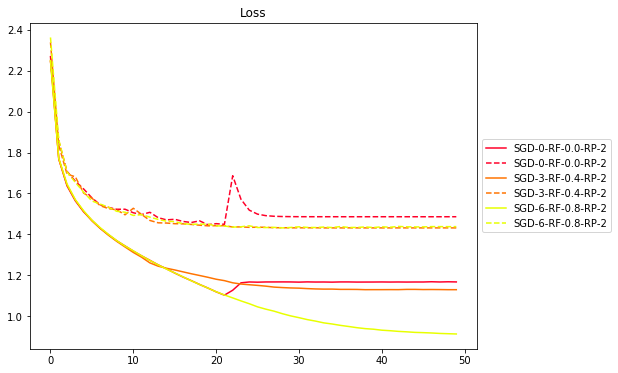

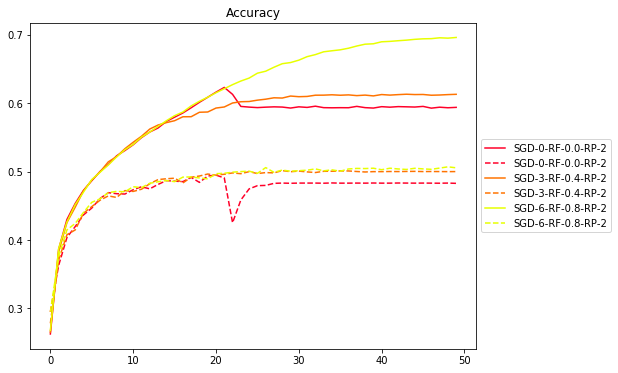

In [49]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i <= 8 and i%3==0:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    if i <= 8 and i%3==0:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()